# Inference on custom data
Last checked and validated with `fastMONAI` version `0.3.2`

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/main/research/spine/01-spine-segmentation-inference.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

In [ ]:
from fastMONAI.vision_all import *
from huggingface_hub import snapshot_download

In [ ]:
#Example data
DATA_DIR = Path('../data')
STUDY_DIR = download_example_spine_data(path=DATA_DIR)

In [ ]:
# Download the models from the study repository and load exported learners 
models_path = Path(snapshot_download(repo_id="skaliy/spine-segmentation",  cache_dir='models'))
learner_list = list(models_path.glob('*learner.pkl'))
loaded_learners = [load_learner(fn, cpu=True) for fn in learner_list]

In [ ]:
# Load variables
vars_fn = models_path/'vars.pkl'
_, reorder, resample = load_variables(pkl_fn=vars_fn)
reorder, resample

(True, [4.4, 0.78, 0.78])

In [ ]:
img_fn = STUDY_DIR/'img.nii.gz'
save_fn = str(img_fn).replace(img_fn.stem, 'pred_' + img_fn.stem)

In [ ]:
#pred_items
org_img, input_img, org_size = med_img_reader(img_fn, reorder, resample, only_tensor=False)

#Predict with ensemble
mask_data = [inference(learner, reorder, resample, org_img=org_img, input_img=input_img, org_size=org_size).data for learner in loaded_learners]

# Average the accumulated mask data
mask_data = sum(mask_data)/len(loaded_learners)

# Threshold the averaged mask data to create a binary mask
mask_data = torch.where(mask_data > 0.5, 1., 0.)

# Apply postprocessing to remove small objects from the binary mask
mask_data = refine_binary_pred_mask(mask_data, remove_size=10437, percentage=0.2)

# Set the data of the image object to the processed mask data and save the predicted mask
org_img.set_data(mask_data)
org_img.save(save_fn)

In [ ]:
from torchio import Subject, ScalarImage, LabelMap

In [ ]:
subject = Subject(image=ScalarImage(img_fn), mask=LabelMap(save_fn))

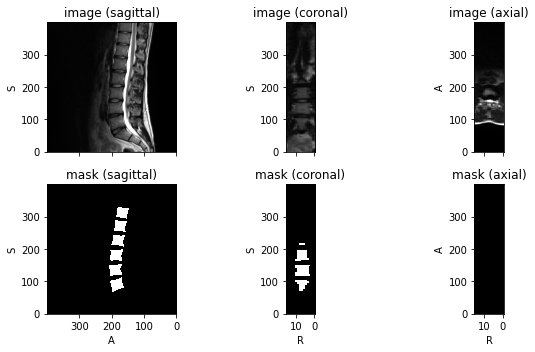

In [ ]:
subject.plot(figsize=(10,5))